<a href="https://colab.research.google.com/github/marinanunes94/comandos-linux/blob/main/pipe_variantes_somaticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ATIVIDADE DE BIOINFORMÁTICA**
## **PIPELINE DE VARIANTES SOMÁTICAS**

**Grupo**

> Andressa Teixeira da Silva,  Geovana de Souza, Giovanna Politi de Nadai, Marina Nunes dos Santos, Marcio da Costa Cipitelli, Raquel Oliveira


**Objetivo geral**: análise de variantes somáticas detectadas em genes de alto risco que são fatores de prognósticos adversos na mielofibrose.

**Escopo**: As neoplasias mieloproliferativas (MPNs) negativas para o cromossomo Filadélfia, que incluem policitemia vera (PV), trombocitemia essencial (ET) e mielofibrose primária (PMF), são doenças adquiridas de células-tronco hematopoéticas clonais caracterizadas pela proliferação anormal e acúmulo de células sanguíneas maduras. Mais de 90% dos casos de mielofibrose abrigam mutações somáticas nos genes controladores JAK2 , CALR ou MPL que levam a uma ativação constitutiva da via JAK-STAT5. 


**Requisitos mínimos do trabalho**:

> **1.** Rodar um pipeline somático e anotação das variantes somáticas no Google Colab.

> **2.** Identificar as amostras com alterações no TP53 e nos genes de alto risco ( EZH2, CBL, U2AF1, SRSF2, IDH1, IDH2, NRAS ou KRAS ) que são fatores de prognósticos adversos em mielofibrose.

## **1ª PARTE: Preparação do ambiente**

In [ ]:
# Montando um drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importação das bibliotecas necessárias para execução do pipeline
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Escolha do diretório de trabalho
%cd /content/drive/MyDrive/pipe_variantes_somaticas

/content/drive/MyDrive/pipe_variantes_somaticas


In [ ]:
# Confirmando que estamos no diretório de interesse
!pwd

/content/drive/MyDrive/pipe_variantes_somaticas


## **2ª PARTE: Análise exploratória dos metadados**

In [ ]:
# Leitura do arquivo de metadados das amostras de Exoma de Mielofibrose (n=30) 
df = pd.read_csv('SraRunTable.txt', sep = ',')
df.head(2)

,Run,Age,Assay Type,AvgSpotLen,Bases,BIOMATERIAL_PROVIDER,BioProject,BioSample,BioSampleModel,Bytes,...,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample Name,sex,SRA Study,Tissue
0,SRR8842300,73,WXS,202,20471572234,HIAE,PRJNA530251,SAMN11309588,Human,14616108221,...,PAIRED,cDNA,GENOMIC,Homo sapiens,ILLUMINA,2020-05-01T00:00:00Z,wp093,male,SRP190048,PB
1,SRR8842301,54,WXS,202,18656192174,HIAE,PRJNA530251,SAMN11309587,Human,13083532823,...,PAIRED,cDNA,GENOMIC,Homo sapiens,ILLUMINA,2020-05-01T00:00:00Z,wp087,female,SRP190048,PB


In [ ]:
# Dados referentes a idade dos pacientes
df['Age'].describe()

count    30.000000
mean     61.900000
std      16.026594
min      21.000000
25%      52.250000
50%      65.000000
75%      75.500000
max      84.000000
Name: Age, dtype: float64

In [ ]:
# Dados referentes ao sexo dos pacientes
df['sex'].describe()

count         30
unique         2
top       female
freq          20
Name: sex, dtype: object

In [ ]:
# Dados referentes ao tecido de coleta dos pacientes
df['Tissue'].describe() # PB: sangue periférico, BM: Medula Óssea

count     30
unique     2
top       PB
freq      16
Name: Tissue, dtype: object

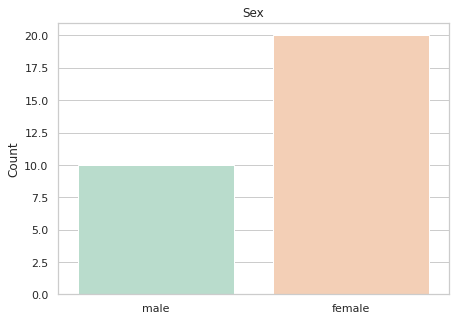

In [ ]:
# Distribuição de pacientes pelo sexo
f, ax = plt.subplots(1, figsize=(7,5))
ax = sns.countplot(x='sex', data=df, palette='Pastel2')
plt.title('Sex')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

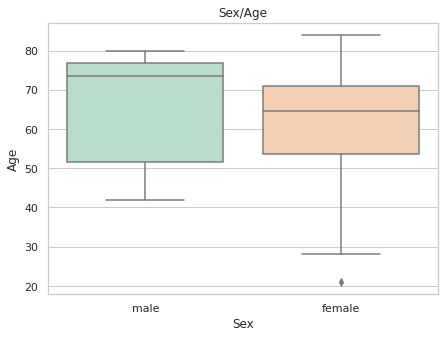

In [ ]:
# Boxplot da relação entre Idade e Sexo dos pacientes
f, ax = plt.subplots(1, figsize=(7,5))
sns.boxplot(data=df, x="sex", y="Age", palette='Pastel2')
plt.title('Sex/Age')
plt.ylabel('Age')
plt.xlabel('Sex')
plt.show()

## **3ª PARTE: Lidando com os arquivos vcf**

As variantes genéticas identificadas são armazenadas em arquivos VCF (Variant Call Format), sendo o VCF um arquivo tabular, formado por 3 principais partes: 1. cabeçalho de metadados. 2. cabeçalho e linhas contendo os dados
e 3. suas devidas anotaçõe.



In [ ]:
# Lib python para manipulação de arquivos vcf (instalação)
%pip install PyVCF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for PyVCF: filename=PyVCF-0.6.8-cp38-cp38-linux_x86_64.whl size=138992 sha256=74d97a4eadc124b5e23b74bd0a0eb978fdcb184edb6dcffa89eb54955ae80617
  Stored in directory: /root/.cache/pip/wheels/f0/3e/15/c1865f9a071eacc7fc702e9c7d25fc752fe5e30a82d0dd405d
Successfully built PyVCF


In [ ]:
# Lib python para manipulação de arquivos vcf (importação)
import vcf

In [ ]:
# Mudando para o diretório dos arquivos vcf
%cd /content/drive/MyDrive/pipe_variantes_somaticas/Imabrasil

/content/drive/MyDrive/pipe_variantes_somaticas/Imabrasil


 **VCFtools** 

VCFtools é um pacote de programas projetado com o objetivo de fornecer métodos acessíveis para trabalhar com dados complexos de variação genética na forma de arquivos VCF.

In [ ]:
# Instalação do VCFtools
!sudo apt-get install vcftools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tabix
The following NEW packages will be installed:
  tabix vcftools
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 778 kB of archives.
After this operation, 3,192 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tabix amd64 1.7-2 [326 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 vcftools amd64 0.1.15-1 [452 kB]
Fetched 778 kB in 2s (383 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
de

In [ ]:
#listar arquivos vcf ordenados 
!ls *.gz

WP048.filtered.vcf.gz  WP140.filtered.vcf.gz  WP216.filtered.vcf.gz
WP056.filtered.vcf.gz  WP160.filtered.vcf.gz  WP270.filtered.vcf.gz
WP060.filtered.vcf.gz  WP162.filtered.vcf.gz  WP274.filtered.vcf.gz
WP064.filtered.vcf.gz  WP164.filtered.vcf.gz  WP276.filtered.vcf.gz
WP066.filtered.vcf.gz  WP170.filtered.vcf.gz  WP280.filtered.vcf.gz
WP072.filtered.vcf.gz  WP180.filtered.vcf.gz  WP285.filtered.vcf.gz
WP078.filtered.vcf.gz  WP188.filtered.vcf.gz  WP291.filtered.vcf.gz
WP087.filtered.vcf.gz  WP196.filtered.vcf.gz  WP295.filtered.vcf.gz
WP093.filtered.vcf.gz  WP204.filtered.vcf.gz  WP297.filtered.vcf.gz
WP126.filtered.vcf.gz  WP212.filtered.vcf.gz  WP306.filtered.vcf.gz


**Para facilitar a análise, decidiu-se por concatenar todos os .vcf em um único arquivo, contendo todos os dados.**

In [ ]:
# Esse comando irá "mesclar" todos os arquivos VCF em um único arquivo que será nomeado como merge.vcf 
!vcf-merge $(ls -x *.gz) > merge.vcf

[W::hts_idx_load2] The index file is older than the data file: WP048.filtered.vcf.gz.tbi
Using column name 'WP048' for WP048.filtered.vcf.gz:WP048
Using column name 'WP049' for WP048.filtered.vcf.gz:WP049
[W::hts_idx_load2] The index file is older than the data file: WP056.filtered.vcf.gz.tbi
Using column name 'WP056' for WP056.filtered.vcf.gz:WP056
Using column name 'WP057' for WP056.filtered.vcf.gz:WP057
[W::hts_idx_load2] The index file is older than the data file: WP060.filtered.vcf.gz.tbi
Using column name 'WP060' for WP060.filtered.vcf.gz:WP060
Using column name 'WP061' for WP060.filtered.vcf.gz:WP061
[W::hts_idx_load2] The index file is older than the data file: WP064.filtered.vcf.gz.tbi
Using column name 'WP064' for WP064.filtered.vcf.gz:WP064
Using column name 'WP065' for WP064.filtered.vcf.gz:WP065
[W::hts_idx_load2] The index file is older than the data file: WP066.filtered.vcf.gz.tbi
Using column name 'WP066' for WP066.filtered.vcf.gz:WP066
Using column name 'WP067' for WP0

In [ ]:
!cat merge.vcf | grep -v "##" | head

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	WP048	WP049	WP056	WP057	WP060	WP061	WP064	WP065	WP066	WP067	WP072	WP073	WP078	WP079	WP087	WP088	WP093	WP094	WP126	WP127	WP140	WP141	WP160	WP161	WP162	WP163	WP164	WP165	WP170	WP171	WP180	WP181	WP188	WP189	WP196	WP197	WP204	WP205	WP212	WP213	WP216	WP217	WP270	WP271	WP274	WP275	WP276	WP277	WP280	WP281	WP285	WP286	WP291	WP292	WP295	WP296	WP297	WP298	WP306	WP307
1	809237	.	C	G	.	contamination;map_qual	AC=3;AN=12;AS_FilterStatus=map_qual,contamination;AS_SB_TABLE=16,23|2,2;DP=166;ECNT=2;GERMQ=22;MBQ=20,27;MFRL=136,129;MMQ=40,29;MPOS=30;NALOD=1.000;NLOD=2.71;POPAF=1.72;SF=11f,17,26;TLOD=6.26	GT:AF:AD:SB:F1R2:DP:F2R1	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	0/1:0.136:26,4:11,15,2,2:9,2:30:6,0	0/0:0.091:13,0:5,8,0,0:3,0:13:6,0	.	.	.	.	.	.	.	.	.	.	0/1:0.173:23,5:12,11,2,3:12,2:28:6,1	0/0:0.067:18,0:7,11,0,0:5,0:18:5,0	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	.	0/1:0.085:53,5:24,29,3,2:17,1:58:22,2	0/0:0.071:17,0:7,10,0,0:3,0:17:8,0	.	.	.	.	.	.
1	809261	.	C	T

## **4ª PARTE: Baixando e indexando o genoma de referência**

Para encontrar as variantes genéticas no nosso dado, precisamos compará-lo com a referência do genoma humano. 

### **1. Baixando o genoma de referência**



In [ ]:
# Mudando de diretório
%cd /content/drive/MyDrive/pipe_variantes_somaticas

/content/drive/MyDrive/pipe_variantes_somaticas


In [ ]:
#Criando diretório referência 
!mkdir referencia
!mkdir referencia/hg19

mkdir: cannot create directory ‘referencia’: File exists
mkdir: cannot create directory ‘referencia/hg19’: File exists


In [ ]:
# Mudando de diretório
%cd /content/drive/MyDrive/pipe_variantes_somaticas/referencia/hg19

/content/drive/MyDrive/pipe_variantes_somaticas/referencia/hg19


 **Download do cromossomo 9**

In [ ]:
!wget -c https://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/chr9.fa.gz

--2023-01-12 20:15:03--  https://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/chr9.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



**Alterando o nome do cabeçalho do arquivo FASTA**
> DE: `>chr9` para `>9`

In [ ]:
!zcat chr9.fa.gz | sed -e "s/chr//g" > chr9.fa

In [ ]:
!head chr9.fa

>9
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


### **2. Indexando o genoma de referência**


Também é necessário indexar esse genoma. O objetivo é, de forma simples, criar um arquivo que permita aos algoritmos de mapeamento localizarem rapidamente qualquer sequência nesse genoma. Sem essa etapa, não seria possível fazer o mapeamento e chamada de variantes.

**Samtools**

É um conjunto de programas para interagir com dados de sequenciamento de alto rendimento. Consiste em três repositórios separados:

> **1.** Samtools: Ler/escrever/editar/indexar/visualizar o formato SAM/BAM/CRAM

> **2.** BCFtools: Ler/escrever arquivos BCF2/VCF/gVCF e chamar/filtrar/resumir SNP e variantes de sequência indel curta

> **3.** HTSlibGenericName: Biblioteca para leitura/gravação de dados de sequenciamento de alto rendimento

In [ ]:
# Instalando Samtools
!sudo apt-get install samtools 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cwltool libc-ares2 libhts2 libjs-bootstrap nodejs nodejs-doc
  python-asn1crypto python-avro python-cachecontrol python-certifi
  python-cffi-backend python-chardet python-cryptography python-enum34
  python-html5lib python-idna python-ipaddress python-isodate python-lockfile
  python-mistune python-openssl python-pkg-resources python-pyparsing
  python-rdflib python-rdflib-jsonld python-requests python-ruamel.yaml
  python-schema-salad python-shellescape python-six python-sparqlwrapper
  python-typing python-urllib3 python-webencodings
Suggested packages:
  python-cryptography-doc python-cryptography-vectors python-enum34-doc
  python-genshi python-lxml python-lockfile-doc python-openssl-doc
  pytho

**samtools faidx**
> index/extract FASTA

Para esse passo, a ferramente utiliza como Input o arquivo 'chr9.fa' e cria o ouput'chr9.fa.fai'

In [ ]:
!samtools faidx chr9.fa

In [ ]:
!head /content/drive/MyDrive/pipe_variantes_somaticas/referencia/hg19/chr9.fa.fai

9	141213431	3	50	51


## **5ª PARTE: Anotação do arquivo VCF**

In [ ]:
# Mudando de diretório
%cd /content/drive/MyDrive/pipe_variantes_somaticas

/content/drive/MyDrive/pipe_variantes_somaticas


- **VEP**

O VEP determina o efeito de suas variantes (SNPs, inserções, deleções, CNVs ou variantes estruturais) em genes, transcritos e sequência de proteínas, bem como regiões reguladoras.

In [ ]:
# Instalando o VEP
%%bash
sudo apt install unzip curl git libmodule-build-perl libdbi-perl libdbd-mysql-perl build-essential zlib1g-dev
wget -c https://github.com/Ensembl/ensembl-vep/archive/refs/tags/105.0.tar.gz
tar -zxvf 105.0.tar.gz

Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
curl is already the newest version (7.58.0-2ubuntu3.22).
git is already the newest version (1:2.17.1-1ubuntu0.13).
unzip is already the newest version (6.0-21ubuntu1.2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2.2).
zlib1g-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libalgorithm-c3-perl libb-hooks-endofscope-perl libb-hooks-op-check-perl
  libclass-c3-perl libclass-c3-xs-perl libclass-method-modifiers-perl
  libclass-xsaccessor-perl libcpan-changes-perl libdata-optlist-perl
  libdata-perl-perl libdata-section-perl libdevel-callchecker-perl
  libdevel-globaldestruction-perl libdynaloader-functions-perl
  libencode-locale-perl libexporter-tiny-pe



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 66.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
--2023-01-13 12:33:14--  https://github.com/Ensembl/ensembl-vep/archive/refs/tags/105.0.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Ensembl/ensembl-vep/tar.gz/refs/tags/105.0 [following]
--2023-01-13 12:33:14--  https://codeload.github.com/Ensembl/ensembl-vep/tar.gz/refs/tags/105.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.git

In [ ]:
%%bash
cd ensembl-vep-105.0
./INSTALL.pl --NO_UPDATE  


Hello! This installer is configured to install v105 of the Ensembl API for use by the VEP.
It will not affect any existing installations of the Ensembl API that you may have.

It will also download and install cache files from Ensembl's FTP server.

Checking for installed versions of the Ensembl API...done

Setting up directories
Destination directory ./Bio already exists.
Do you want to overwrite it (if updating VEP this is probably OK) (y/n)? Exiting


In [ ]:
%%bash 
/content/drive/MyDrive/pipe_variantes_somaticas/ensembl-vep-105.0/vep --help 

#----------------------------------#
# ENSEMBL VARIANT EFFECT PREDICTOR #
#----------------------------------#

Versions:
  ensembl              : 105.525fbcb
  ensembl-funcgen      : 105.660df8f
  ensembl-io           : 105.2a0a40c
  ensembl-variation    : 105.ac8178e
  ensembl-vep          : 105.0

Help: dev@ensembl.org , helpdesk@ensembl.org
Twitter: @ensembl

http://www.ensembl.org/info/docs/tools/vep/script/index.html

Usage:
./vep [--cache|--offline|--database] [arguments]

Basic options

--help                 Display this message and quit

-i | --input_file      Input file
-o | --output_file     Output file
--force_overwrite      Force overwriting of output file
--species [species]    Species to use [default: "human"]
                       
--everything           Shortcut switch to turn on commonly used options. See web
                       documentation for details [default: off]                       
--fork [num_forks]     Use forking to improve script runtime

For full o

In [ ]:
%%bash
cd ensembl-vep-105.0
./vep

#----------------------------------#
# ENSEMBL VARIANT EFFECT PREDICTOR #
#----------------------------------#

Versions:
  ensembl              : 105.525fbcb
  ensembl-funcgen      : 105.660df8f
  ensembl-io           : 105.2a0a40c
  ensembl-variation    : 105.ac8178e
  ensembl-vep          : 105.0

Help: dev@ensembl.org , helpdesk@ensembl.org
Twitter: @ensembl

http://www.ensembl.org/info/docs/tools/vep/script/index.html

Usage:
./vep [--cache|--offline|--database] [arguments]

Basic options

--help                 Display this message and quit

-i | --input_file      Input file
-o | --output_file     Output file
--force_overwrite      Force overwriting of output file
--species [species]    Species to use [default: "human"]
                       
--everything           Shortcut switch to turn on commonly used options. See web
                       documentation for details [default: off]                       
--fork [num_forks]     Use forking to improve script runtime

For full o

### **Dicionário da configuração escolhida para a anotação com o VEP**

> **Opções básicas**

* -v: Print um pouco mais de informação durante a execução.
* -i: Nome do Input.
* -o: Nome do Output.
* --fork [num_forks]: Habilita a função Fork, o que acelera a execução.

> **Opcões de cache**

* --cache: habilita o uso de cache.
* --fasta [file|dir]: Especifique um arquivo FASTA ou um diretório contendo arquivos FASTA a serem usados ​​para pesquisar a sequência de referência. Na primeira vez que você executar o VEP com esse parâmetro, um índice será criado, o que pode levar alguns minutos.
* --offline: Nenhuma conexão com o banco de dados será feita e um arquivo de cache é necessário para anotação. Adicione --refseq para usar o cache refseq (se instalado).
* --refseq: Especifique esta opção se você tiver instalado o cache RefSeq para que o VEP selecione o diretório de cache alternativo. Este cache contém objetos de transcrição correspondentes às transcrições RefSeq. 

> **Opções de formato de saída**

* --variant_class: Gera a classe da variante.
* --gene_phenotype: Indica se o gene está associado a um fenótipo, doença ou característica.
* -- Individual [all|ind list]: Considera apenas alelos alternativos presentes nos genótipos do(s) indivíduo(s) especificado(s). Pode ser um único indivíduo, uma lista separada por vírgulas ou "todos" para avaliar todos os indivíduos separadamente. Combinações de variantes individuais homozigóticas para o alelo de referência fornecido não serão relatadas. Cada combinação individual e variante é dada em uma linha separada de saída. Funciona apenas com arquivos VCF contendo dados de genótipos individuais; os IDs individuais são obtidos dos cabeçalhos das colunas.
* --tab: Grava a saída no formato delimitado por tabulações.

> **Filtros**

* --pick: Escolhe uma linha ou bloco de dados por variante, incluindo colunas específicas de transcrição.
* --pick_allele: Como --pick, mas escolhe uma linha ou bloco de dados de  por alelo variante. Só será diferente em comportamento de --pick quando a variante de entrada tiver vários alelos alternativos.
* --filter_common: excluirá variantes que possuem uma variante existente co-localizada com AF global > 0,01 (1%).

> **Identificadores**
* --symbol: 	Adiciona o símbolo do gene (por exemplo, HGNC) (quando disponível).
* --protein: Adiciona o identificar da proteína.

> **Database**
* --database: Enable VEP to use local or remote databases.

**OBSERVAÇÃO: Devido as limitações do COLAB, foi necessário reduzir o número de fields para que fosse possível executar o VEP para anotação de 30 amostras ao mesmo tempo.**

In [ ]:
%%bash
/content/drive/MyDrive/pipe_variantes_somaticas/ensembl-vep-105.0/vep \
  --fork 3\
  -i /content/drive/MyDrive/pipe_variantes_somaticas/Imabrasil/merge.vcf \
  -o /content/drive/MyDrive/pipe_variantes_somaticas/anotacao/anotacao.vcf.tsv \


  --dir_cache /content/drive/Shareddrives/T4-2022/MarinaNunes \
  --cache \
  --database --assembly GRCh37 --refseq  \

	--pick --pick_allele --force_overwrite --tab --symbol --check_existing\
  --fields "Location, SYMBOL, Consequence, Feature, Amino_acids, CLIN_SIG, IND" \
	--fasta /content/drive/MyDrive/pipe_variantes_somaticas/referencia/hg19/chr9.fa \
	--individual all 

**Visualizando o arquivo de anotação (annotation.vep.tsv)**

In [ ]:
anotacao = pd.read_csv('/content/drive/MyDrive/pipe_variantes_somaticas/anotacao/anotacao.vcf.tsv', sep='\t', skiprows= 38)
anotacao.head(2)

,#Uploaded_variation,Location,Allele,Existing_variation,HGVSc,HGVSp,SYMBOL,Consequence,IND,ZYG,Amino_acids,CLIN_SIG,PolyPhen,SIFT,VARIANT_CLASS,FREQS
0,1_809237_C/G,1:809237,G,rs200657693,NR_027055.1:n.1101+255G>C,-,FAM41C,"intron_variant,non_coding_transcript_variant",WP160,HET,-,-,-,-,SNV,-
1,1_809237_C/G,1:809237,G,rs200657693,NR_027055.1:n.1101+255G>C,-,FAM41C,"intron_variant,non_coding_transcript_variant",WP196,HET,-,-,-,-,SNV,-


In [ ]:
# Merge do dataframe de metadados com o dataframe de Anotação
df['IND'] = df['Sample Name'].str.upper()
anotacao = pd.merge(anotacao, df, on = 'IND')
anotacao.head(2)

,#Uploaded_variation,Location,Allele,Existing_variation,HGVSc,HGVSp,SYMBOL,Consequence,IND,ZYG,...,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample Name,sex,SRA Study,Tissue
0,1_809237_C/G,1:809237,G,rs200657693,NR_027055.1:n.1101+255G>C,-,FAM41C,"intron_variant,non_coding_transcript_variant",WP160,HET,...,PAIRED,cDNA,GENOMIC,Homo sapiens,ILLUMINA,2020-05-01T00:00:00Z,wp160,female,SRP190048,BM
1,1_809261_C/T,1:809261,T,rs202083165,NR_027055.1:n.1101+231G>A,-,FAM41C,"intron_variant,non_coding_transcript_variant",WP160,HET,...,PAIRED,cDNA,GENOMIC,Homo sapiens,ILLUMINA,2020-05-01T00:00:00Z,wp160,female,SRP190048,BM


##**ÚLTIMA ETAPA: Análise exploratória dos dados anotados**

In [ ]:
#Confirmação de que todas as Amostras foram anotadas corretamente pelo VEP

anotacao['IND'].unique()

array(['WP160', 'WP196', 'WP291', 'WP188', 'WP306', 'WP180', 'WP276',
       'WP216', 'WP295', 'WP064', 'WP066', 'WP126', 'WP285', 'WP270',
       'WP048', 'WP056', 'WP087', 'WP162', 'WP164', 'WP170', 'WP204',
       'WP297', 'WP274', 'WP072', 'WP093', 'WP280', 'WP140', 'WP212',
       'WP078', 'WP060'], dtype=object)

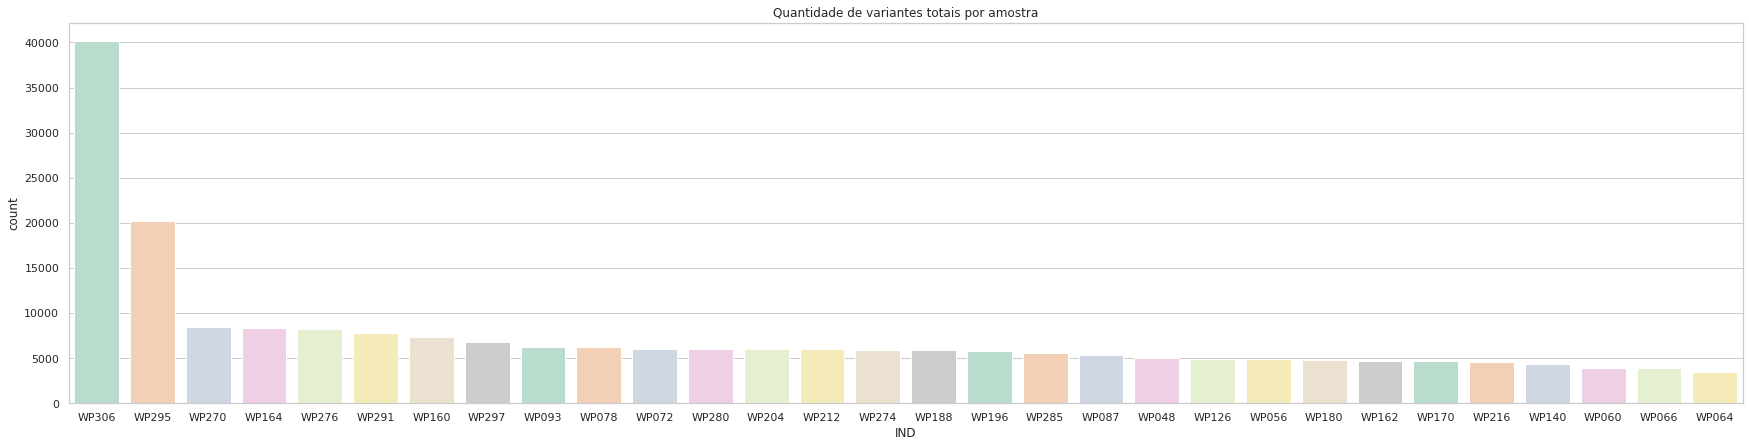

In [ ]:
# Quantidade de Variantes totais por amostra

sns.set_theme(style="whitegrid")
sns.husl_palette(as_cmap=True)
plt.figure(figsize=(30,7))
variantes = sns.countplot(data=anotacao, x = 'IND', order=anotacao.IND.value_counts().index, palette='Pastel2')
variantes.set_title("Quantidade de variantes totais por amostra")
variantes

In [ ]:
# Tipos de variantes mais comuns observadas nas amostras

anotacao['Consequence'].value_counts()

intron_variant                                                                                           87664
missense_variant                                                                                         57909
synonymous_variant                                                                                       22358
splice_polypyrimidine_tract_variant,intron_variant                                                        8834
3_prime_UTR_variant                                                                                       7845
                                                                                                         ...  
inframe_insertion,splice_region_variant                                                                      1
splice_donor_variant,splice_polypyrimidine_tract_variant,splice_donor_region_variant,intron_variant          1
splice_acceptor_variant,frameshift_variant                                                                   1
s

In [ ]:
# Filtro de variantes intrônicas

variantes_int = anotacao[(anotacao["Consequence"].str.contains('intron'))]

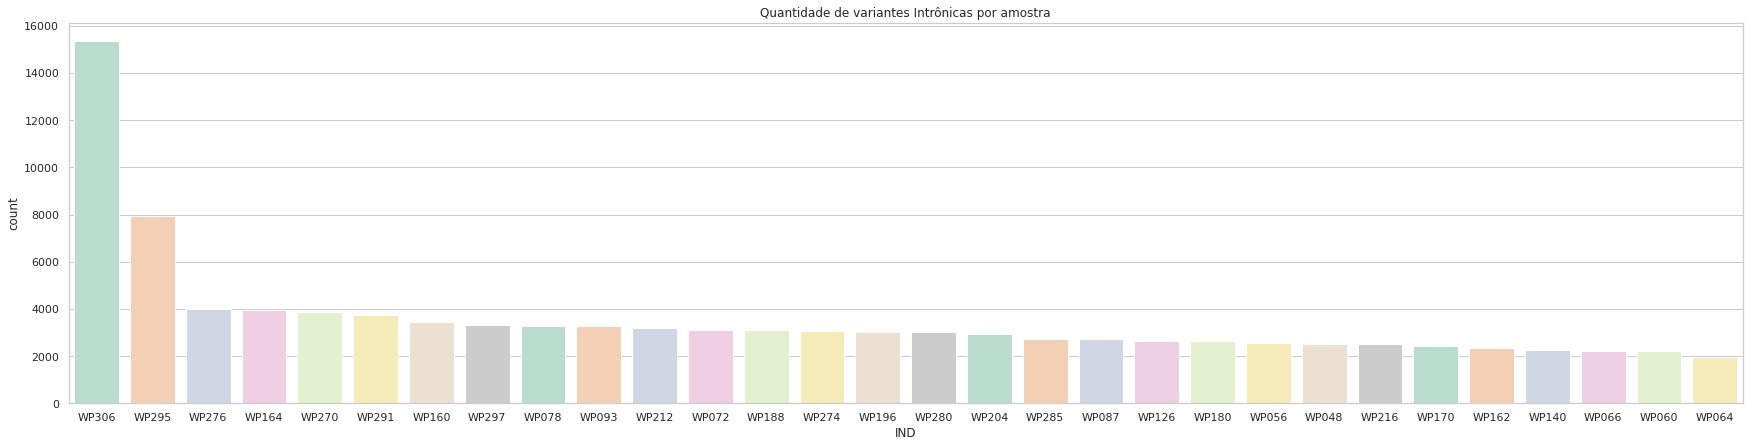

In [ ]:
# Gráfico obtido por meio do filtro de variantes Intrônicas por amostra

sns.set_theme(style="whitegrid")
sns.husl_palette(as_cmap=True)
plt.figure(figsize=(30,7))
variantes = sns.countplot(data=variantes_int, x = 'IND', order=variantes_int.IND.value_counts().index, palette='Pastel2')
variantes.set_title("Quantidade de variantes Intrônicas por amostra")
variantes

In [ ]:
# Filtro de variantes intrônicas

variantes_mis = anotacao[(anotacao["Consequence"].str.contains('missense'))]

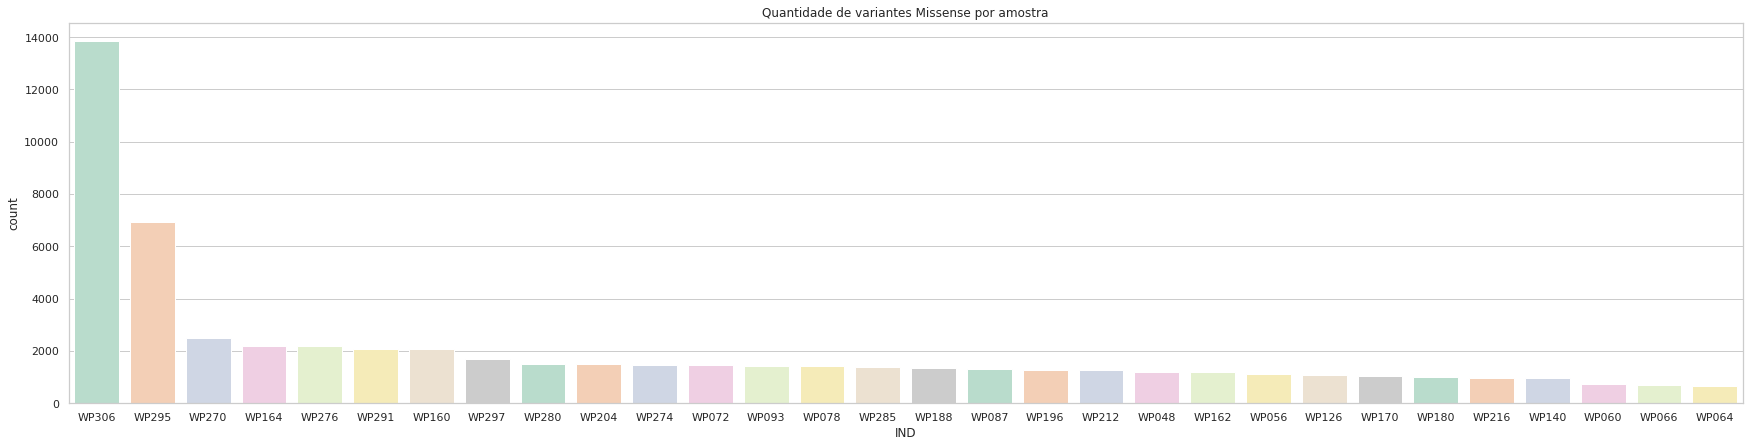

In [ ]:
# Gráfico obtido por meio do filtro de variantes Missense por amostra

sns.set_theme(style="whitegrid")
sns.husl_palette(as_cmap=True)
plt.figure(figsize=(30,7))
variantes = sns.countplot(data=variantes_mis, x = 'IND', order=variantes_mis.IND.value_counts().index, palette='Pastel2')
variantes.set_title("Quantidade de variantes Missense por amostra")
variantes

In [ ]:
# Filtro de variantes intrônicas e missense

variantes_totais = anotacao[(anotacao["Consequence"].str.contains('missense|intron'))]

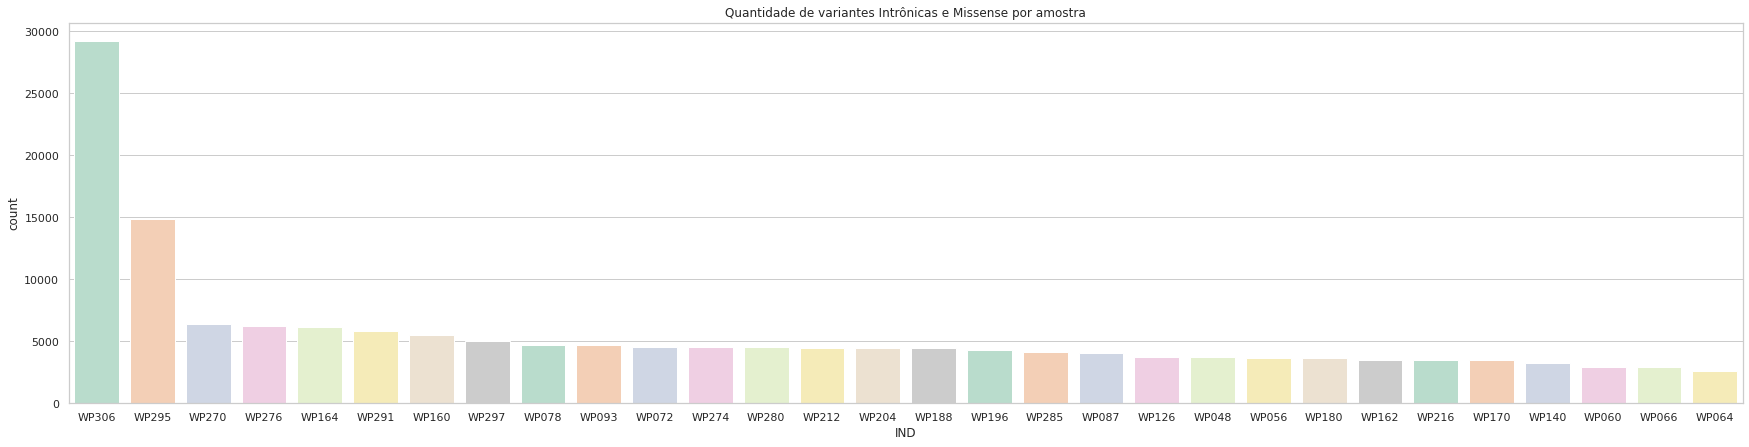

In [ ]:
# Gráfico obtido por meio do filtro de variantes intrônicas e missense por amostra

sns.set_theme(style="whitegrid")
sns.husl_palette(as_cmap=True)
plt.figure(figsize=(30,7))
variantes = sns.countplot(data=variantes_totais, x = 'IND', order=variantes_totais.IND.value_counts().index, palette='Pastel2')
variantes.set_title("Quantidade de variantes Intrônicas e Missense por amostra")
variantes

In [ ]:
# Construção de um filtro para abordagem apenas dos genes de interesse
genes = anotacao[(anotacao["SYMBOL"].str.contains('TP53|EZH2|CBL|U2AF1|SRSF2|IDH1|IDH2|NRAS|KRAS|JAK2|CALR|MPL'))]
genes.head(2)

,#Uploaded_variation,Location,Allele,Existing_variation,HGVSc,HGVSp,SYMBOL,Consequence,IND,ZYG,...,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample Name,sex,SRA Study,Tissue
2603,6_117824867_C/A,6:117824867,A,-,NM_001366458.2:c.113-63C>A,-,DCBLD1,intron_variant,WP160,HET,...,PAIRED,cDNA,GENOMIC,Homo sapiens,ILLUMINA,2020-05-01T00:00:00Z,wp160,female,SRP190048,BM
4043,11_44958550_G/T,11:44958550,T,-,NM_001258320.2:c.238-100C>A,-,TP53I11,intron_variant,WP160,HET,...,PAIRED,cDNA,GENOMIC,Homo sapiens,ILLUMINA,2020-05-01T00:00:00Z,wp160,female,SRP190048,BM


In [ ]:
# Descrição dos genes de interesse

genes['SYMBOL'].describe() #Podemos observar que o resultado mais comum foi TP53, aparecendo 46 vezes

count         333
unique         33
top       TP53BP1
freq           46
Name: SYMBOL, dtype: object

Text(0.5, 1.0, 'Número de mutações de genes de interesse por indivíduo')

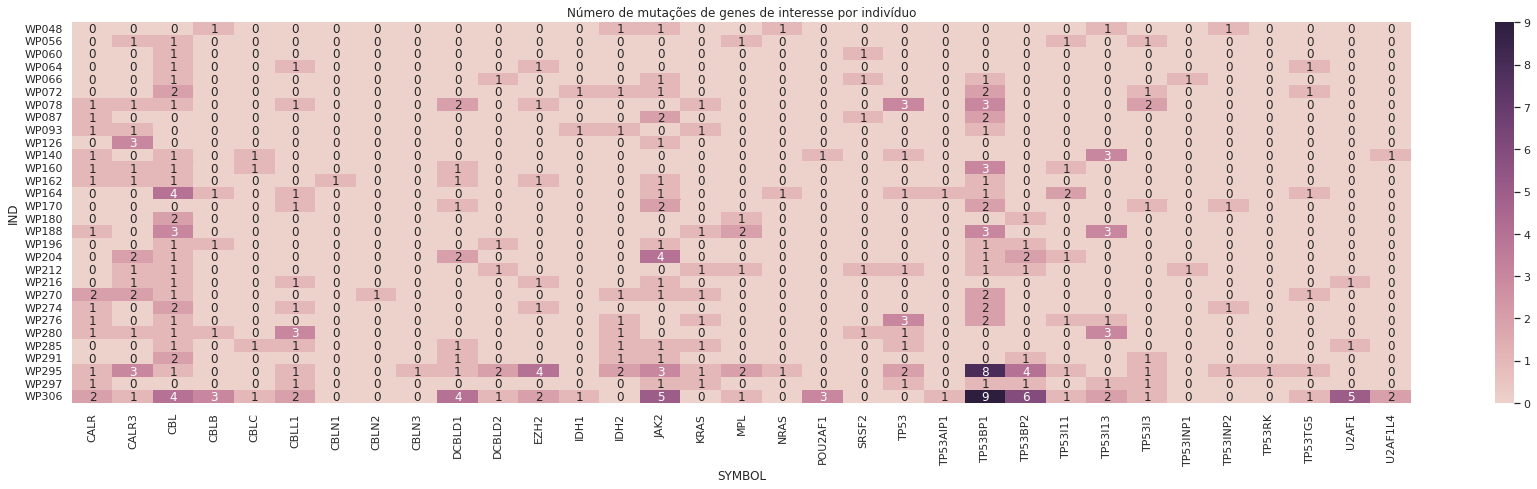

In [ ]:
# Heatmap da quantidade de mutações dos genes de interesse por amostra

genes = genes.set_index('IND').groupby(['IND'])['SYMBOL'].value_counts().reset_index(name="count")
genes = genes.pivot(index=['IND'], columns='SYMBOL', values='count')
genes = genes.fillna(0)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30,7))
genes = sns.heatmap(genes, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
genes.set_title("Número de mutações de genes de interesse por indivíduo")

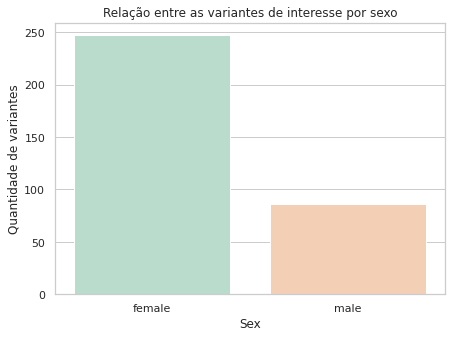

In [ ]:
# Relação entre as variantes de interesse por sexo
f, ax = plt.subplots(1, figsize=(7,5))
sns.set_theme(style="whitegrid", palette='Pastel2')
sex = sns.countplot(data=genes, x = 'sex', order= genes.sex.value_counts().index)

plt.title('Relação entre as variantes de interesse por sexo')
plt.ylabel('Quantidade de variantes')
plt.xlabel('Sex')
plt.show()


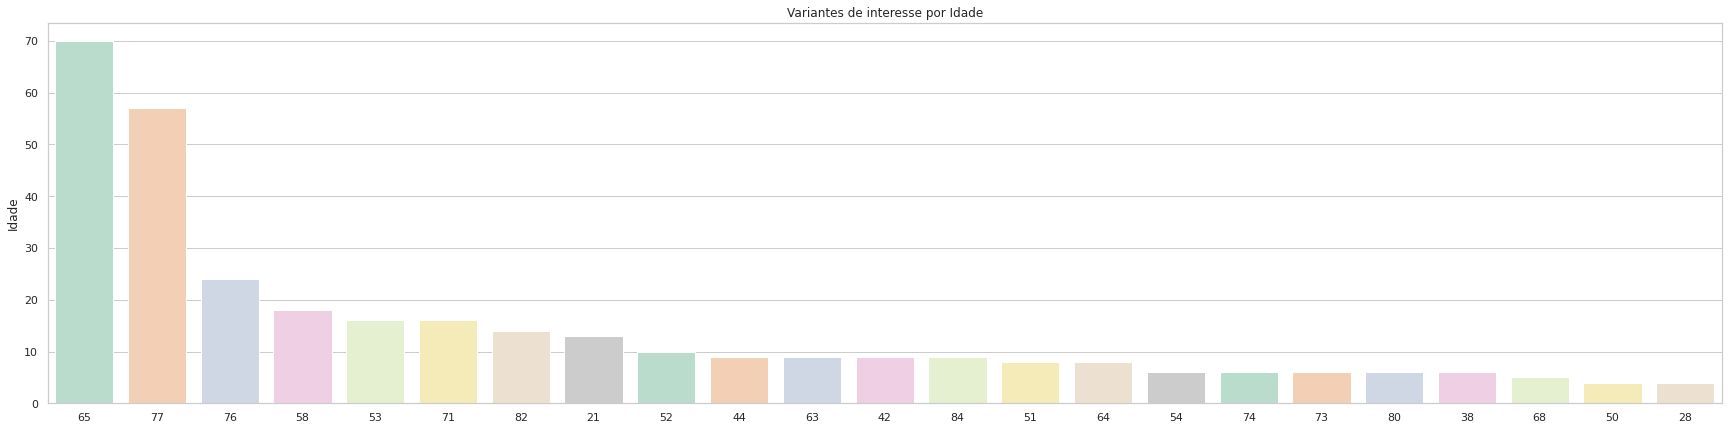

In [ ]:
# Relação entre as variantes de interesse por idade
f, ax = plt.subplots(1, figsize=(30,7))
sns.set_theme(style="whitegrid")
sex = sns.countplot(data=genes, x = 'Age', order= genes.Age.value_counts().index, palette='Pastel2')

plt.title('Variantes de interesse por Idade')
plt.ylabel('Idade')
plt.xlabel('')
plt.show()

In [ ]:
# Nesse momento, visualizar todas as colunas do dataset facilita sua análise
pd.set_option('display.max_rows', 227)

In [ ]:
# Quantidade de genes de interesse por amostra 

genes = genes.groupby(['IND'])['SYMBOL'].value_counts()
genes = genes.to_frame()

In [ ]:
# Transpose da tabela 
genes = genes.T

In [ ]:
genes

IND    WP048                                 WP056                  ...  \
SYMBOL  CBLB IDH2 JAK2 NRAS TP53I13 TP53INP2 CALR3 CBL MPL TP53I11  ...   
SYMBOL     1    1    1    1       1        1     1   1   1       1  ...   

IND      WP306                                                             
SYMBOL U2AF1L4 CALR3 CBLC DCBLD2 IDH1 MPL TP53AIP1 TP53I11 TP53I3 TP53TG5  
SYMBOL       2     1    1      1    1   1        1       1      1       1  

[1 rows x 227 columns]

In [ ]:
 # Descrição dos dados 
 genes.describe()

IND    WP048                                 WP056                    ...  \
SYMBOL  CBLB IDH2 JAK2 NRAS TP53I13 TP53INP2 CALR3  CBL  MPL TP53I11  ...   
count    1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   
mean     1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   
std      NaN  NaN  NaN  NaN     NaN      NaN   NaN  NaN  NaN     NaN  ...   
min      1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   
25%      1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   
50%      1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   
75%      1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   
max      1.0  1.0  1.0  1.0     1.0      1.0   1.0  1.0  1.0     1.0  ...   

IND      WP306                                                              
SYMBOL U2AF1L4 CALR3 CBLC DCBLD2 IDH1  MPL TP53AIP1 TP53I11 TP53I3 TP53TG5  
count      1.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  
mean       2.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  
std        NaN   NaN  NaN    NaN  NaN  NaN      NaN     NaN    NaN     NaN  
min        2.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  
25%        2.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  
50%        2.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  
75%        2.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  
max        2.0   1.0  1.0    1.0  1.0  1.0      1.0     1.0    1.0     1.0  

[8 rows x 227 columns]